In [0]:
%%capture
!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80

In [0]:
from google.colab import files
from glob import glob
from PIL import Image
import os
import numpy as np
import cupy as cp
# import matplotlib
# matplotlib.use("Agg")
import matplotlib.animation as manimation
import matplotlib.pyplot as plt
import zipfile
# import sys

# making one long image `XXXX x 1080`

In [33]:
uploaded = files.upload()
for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

Saving overdrive_brass.wav to overdrive_brass.wav
User uploaded file "overdrive_brass.wav" with length 4911148 bytes


In [34]:
from scipy.io import wavfile
rate, track = wavfile.read('overdrive_brass.wav') # now supports only mono .wav files
print(f'rate {rate}')

wav_dtype = track.dtype

wav_max = np.iinfo(wav_dtype).max
wav_min = np.iinfo(wav_dtype).min

track = track.astype(np.float32)
track = (track - wav_min) * 2 / (wav_max - wav_min) -1 # normalise -1..1

print(track.dtype)
# track = x[:20000]
# left_channel  = x[:, 0]
# right_channel = x[:, 1]
# track = left_channel
# average left and right channels to mono signal (reaaly bad, don't do this)
# track = (left_channel + right_channel) / 2 
n = len(track)
seconds = n/rate 
print(f'{seconds} seconds')
t = np.linspace(0, seconds, n, dtype=track.dtype)
print(t.dtype)
# plt.grid()
# plt.plot(t, track, 'k-', linewidth=0.1)
# track_chunks = track_to_chunks(track)
# print(track_chunks.shape)

rate 44100
float32
55.68145124716553 seconds
float32


In [35]:
track.shape[0]

2455552

In [44]:
nperseg  = 10000
noverlap = 9000
step = nperseg - noverlap

x = track
shape   = ((x.shape[-1] - noverlap) // step, nperseg)
strides = (step * x.strides[-1], x.strides[-1])
track_rolled = cp.array(np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides))
track_rolled.shape

(2446, 10000)

In [0]:
frame_height = 1080

t = np.linspace(0, nperseg / rate, nperseg, dtype=track.dtype)
f = np.geomspace(30, nperseg // 2, frame_height) # second arg: nperseg//2 (Nyquist limit)    
T, F = np.meshgrid(t, f)

In [0]:
E = cp.array(np.exp(-2j * np.pi * F * T), dtype=np.complex64) # complex64: Complex number, represented by two 32-bit floats (real and imaginary components)

In [47]:
E.T.shape

(10000, 1080)

In [0]:
corr = cp.dot(track_rolled, E.T)
magnitude = cp.abs(corr)
#     print(magnitude.shape)
#     column = cp.asnumpy(magnitude.T)
spectrogram = cp.asnumpy(magnitude.T)
#   column = magnitude

In [49]:
spectrogram.shape

(1080, 2446)

In [0]:
plt.imsave('spectrogram.png', spectrogram, cmap='viridis', origin='lower')
files.download('spectrogram.png')

# plt.figure(figsize=(20, 20))
# plt.imshow(spectrogram, cmap='viridis', origin='lower')
# plt.grid(False)

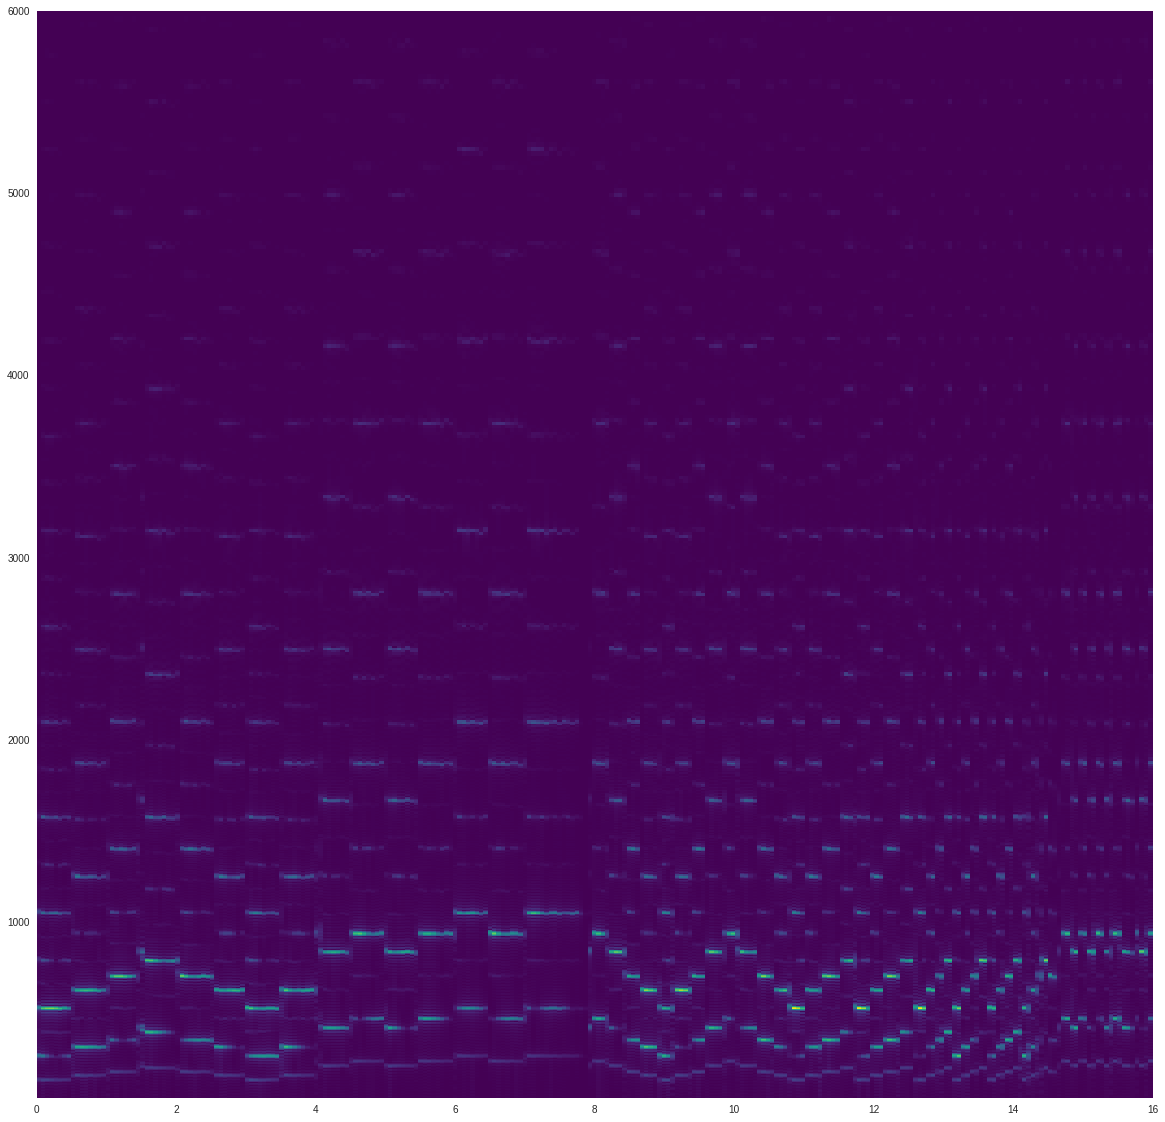

In [30]:
plt.figure(figsize=(20, 20))
t_spec = np.linspace(0, seconds, track_rolled.shape[0])
T_SPEC, F = np.meshgrid(t_spec, f)

plt.pcolormesh(T_SPEC, F, spectrogram, cmap='viridis')
# plt.semilogy()
plt.grid(False)
# plt.show()